## Non identifiable regression in variation inference
Consider a random variable $X \sim N(\gamma * \theta, 1)$ with the parameters $\gamma \in R$ and $\theta \in R$.


The problem is non-identifiable because we only care about the product $\gamma*\theta$, and hence we have infinitely many optimal solutions $\hat{\theta}, \hat{\gamma}$ s.t. $\hat{\theta}* \hat{\gamma} = \theta*\gamma = \mu$, where we have defined $\mu=\theta*\gamma$.

For example, if $\mu=2$ we get the following optimal lines when $-2<\gamma<2$ and $\gamma \neq 0$:

/opt/conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


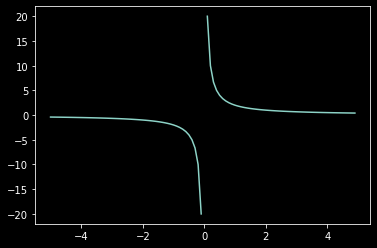

In [1]:
import numpy as np
import matplotlib.pyplot as plt
mu = 2
gamma = np.arange(-5.0,5, 0.1).round(2)
theta = mu/gamma
plt.plot(gamma, theta)

## Posterior distribution
We want to find the posterior distribution of X given some data $x_1, x_2, ..., x_n$.

We put improper flat priors on the parameters: $\gamma \sim 1$, $\theta \sim 1$.
The posterior distribution is then 

$$P(\theta, \gamma | x_1, .., x_n) \sim \prod_{i=1}^n N(x_i; \theta * \gamma, 1) = N(\mu; \frac{1}{n} \sum_{i=1}^n x_i, \frac{1}{\sqrt{n}}):= N(\mu; \bar{x}, \bar{ \sigma})$$

where the second equality is the result of multiplying i.i.d. gaussian pdfs, and the last is a definition.

So the product of $\gamma* \theta$ has a fixed posterior distribution, but they have an intricate dependency between each other.

## Find the posterior using MCMC

In [2]:
# Simulate some data
import torch
import pyro
import pyro.distributions as dist
n = 10
mu = 2
var = 1
x = dist.Normal(mu,var).sample((n,))
x_bar = x.mean()
sigma_bar = x.std()
x_bar, sigma_bar, var

(tensor(2.3917), tensor(1.0019), 1)

In [19]:
# Define the prior + likelihood using pyro in the model function model()
# We will aproximate the flat priors with uniform(-5,5)
def model(x):
    theta = pyro.sample("theta", dist.Uniform(-1e6,1e6))
    gamma = pyro.sample("gamma", dist.Uniform(-1e6,1e6))
    var = 1#pyro.sample("var", dist.Uniform(0,3))
    mu = theta*gamma
    mu, theta, gamma
    with pyro.plate("obs", size = n):
        obsdistr = dist.Normal(mu.repeat(n,),1) # var.repeat(n,)
        obs = pyro.sample("x", obsdistr, obs=x)
    return mu


from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model, step_size = 0.1, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
#mcmc.run(x)
#hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

### Plot sample distributions of the parameters
We can inspect the posterior by plotting the distribution of $\hat{\mu}$, the marginal distributions of $\hat{\gamma}, \hat{\theta}$ and the joint distribution of the two.

As expected, we see the product distribution looks gaussian, the marginal looks ("quite") flat and the joint distribution has settled on one quadrant of the possible solution given above.

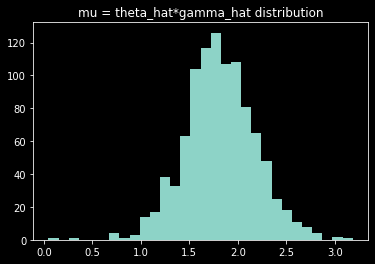

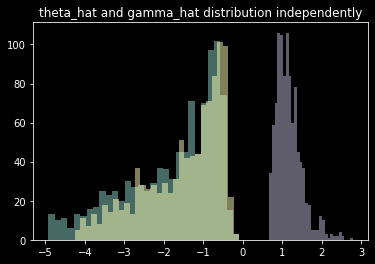

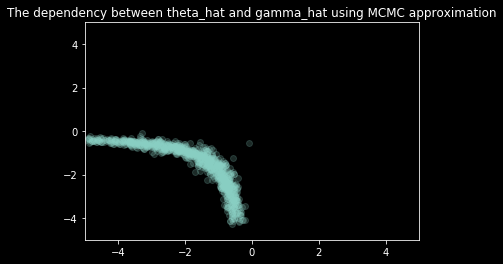

In [16]:
theta_hat = hmc_samples['theta']
gamma_hat = hmc_samples['gamma']
var_hat = hmc_samples['var']
_ = plt.hist(theta_hat*gamma_hat, bins = 30)
plt.title("mu = theta_hat*gamma_hat distribution")
plt.show()

_ = plt.hist(theta_hat, bins = 30, alpha=0.5)
_ = plt.hist(gamma_hat, bins = 30, alpha=0.5)
_ = plt.hist(var_hat, bins = 30, alpha=0.5)

_ = plt.title("theta_hat and gamma_hat distribution independently")
plt.show()

_ = plt.scatter(theta_hat, gamma_hat, alpha = 0.2)
plt.xlim(-5,5)
plt.ylim(-5,5)
_ = plt.title("The dependency between theta_hat and gamma_hat using MCMC approximation")

## Find posterior distribution using mean-field Variational Inference
We can use the same model() object defined above, but we need to introduce an approximate variational distribution in the guide.

In [34]:
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
import pyro.optim as optim

rng = lambda: torch.rand((1,))[0]-0.5

def guide(x):
    param = {}
    distr = {}
    param['theta_mean'] = pyro.param("theta-mean", torch.tensor(500.5))
    param['theta_scale'] = pyro.param("theta-scale", 0.5 + rng(), constraint= constraints.positive)
    distr['theta'] = dist.Normal(param['theta_mean'], param['theta_scale'])
    pyro.sample("theta", distr['theta'])

    param['gamma_mean'] = pyro.param("gamma-mean", torch.tensor(0.5))
    param['gamma_scale'] = pyro.param("gamma-scale", rng()+0.5, constraint= constraints.positive)
    distr['gamma'] = dist.Normal(param['gamma_mean'],param['gamma_scale'])
    pyro.sample("gamma", distr['gamma'])

    #param['var_mean'] = pyro.param("var-mean", 3*rng())
    #param['var_scale'] = pyro.param("var-scale", rng()+0.5, constraint= constraints.positive)
    #distr['var'] = dist.Normal(param['var_mean'],param['var_scale'])
    #pyro.sample("var", distr['var'])
    return param, distr

In [45]:
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
import pyro.optim as optim
import logging

svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

#pyro.clear_param_store()
num_iters = 20000
for i in range(num_iters):
    elbo = svi.step(x)
    if i % 500 == 0:
        print(f"Elbo loss: {elbo:.2f}")



Elbo loss: 44.67
Elbo loss: 43.06
Elbo loss: 46.26
Elbo loss: 43.40
Elbo loss: 44.35
Elbo loss: 44.72
Elbo loss: 42.12
Elbo loss: 46.27
Elbo loss: 44.40
Elbo loss: 46.15
Elbo loss: 44.20
Elbo loss: 45.06
Elbo loss: 45.63
Elbo loss: 43.99
Elbo loss: 43.17
Elbo loss: 44.41
Elbo loss: 43.90
Elbo loss: 44.46
Elbo loss: 43.92
Elbo loss: 43.68
Elbo loss: 44.62
Elbo loss: 43.63
Elbo loss: 44.12
Elbo loss: 46.53
Elbo loss: 45.39
Elbo loss: 43.78
Elbo loss: 43.61
Elbo loss: 43.69
Elbo loss: 43.57
Elbo loss: 44.11
Elbo loss: 43.96
Elbo loss: 45.07
Elbo loss: 44.03
Elbo loss: 43.98
Elbo loss: 44.63
Elbo loss: 44.37
Elbo loss: 44.75
Elbo loss: 43.53
Elbo loss: 44.09
Elbo loss: 43.66


### Visualizing the Variational Inference plots
We may plot the same distributional graphs with VI as we did with the MCMC distribution:

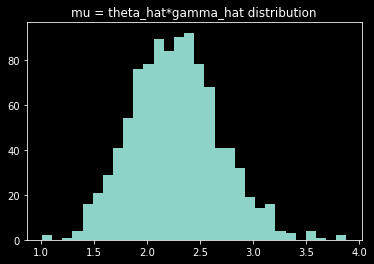

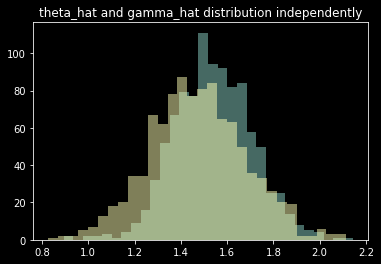

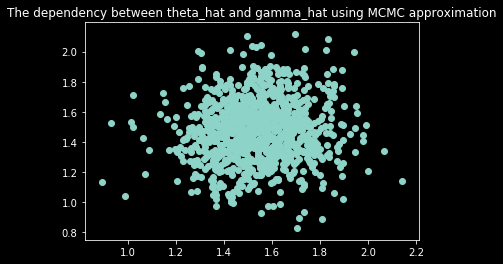

In [46]:
par, distr = guide(x)
samples = {key : distr.sample((1000,)) for key, distr in distr.items()}

theta_hat = samples['theta']
gamma_hat = samples['gamma']
#var_hat = samples['var']
_ = plt.hist(theta_hat*gamma_hat, bins = 30)
plt.title("mu = theta_hat*gamma_hat distribution")
plt.show()

_ = plt.hist(theta_hat, bins = 30, alpha=0.5)
_ = plt.hist(gamma_hat, bins = 30, alpha=0.5)
#_ = plt.hist(var_hat, bins = 30, alpha=0.5)
_ = plt.title("theta_hat and gamma_hat distribution independently")
plt.show()

_ = plt.scatter(theta_hat, gamma_hat)
#plt.xlim(-5,5)
#plt.ylim(-5,5)
_ = plt.title("The dependency between theta_hat and gamma_hat using MCMC approximation")

In [40]:
pyro.param("theta-mean")#, pyro.param("theta-mean")

tensor(489.8173, requires_grad=True)

We see that the VI approximation is surprising good at modelling $\hat{\mu}$. The distribution looks surprising similar to the one found by MCMC.
The mode is shifted to the left, but that is actually closer to the true mean value(!).

However, the variational distribution completely breaks down in the marginal case, and only finds one "point" on the optimal line found by MCMC.
By starting the VI algorithm in different starting positions, it ends up in different points.


### Compare the VI solution vs MCMC solution

In [14]:
for s in [hmc_samples, samples]:
    theta_hat = s['theta']
    gamma_hat = s['gamma']
    var_hat = s['var']
    _ = plt.scatter(theta_hat, gamma_hat, alpha=0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)

NameError: name 'hmc_samples' is not defined

## Different starting points for VI
What happens with the VI solution for different starting points? We initialize the algorithm in different random points sampling the variational means from [-0.5, 0.5] and the scales from [0,1] uniformly.


---
run 0
Elbo loss: 59.87
Elbo loss: 27.61
Elbo loss: 28.91
Elbo loss: 28.00
Elbo loss: 28.69

---
run 1
Elbo loss: 75.85
Elbo loss: 28.83
Elbo loss: 29.14
Elbo loss: 28.21
Elbo loss: 28.88

---
run 2
Elbo loss: 46.52
Elbo loss: 29.15
Elbo loss: 28.92
Elbo loss: 28.61
Elbo loss: 28.33

---
run 3
Elbo loss: 43.79
Elbo loss: 29.02
Elbo loss: 29.29
Elbo loss: 29.17
Elbo loss: 31.62

---
run 4
Elbo loss: 55.01
Elbo loss: 28.41
Elbo loss: 29.37
Elbo loss: 27.96
Elbo loss: 30.27

---
run 5
Elbo loss: 82.44
Elbo loss: 31.30
Elbo loss: 24.71
Elbo loss: 30.25
Elbo loss: 28.84

---
run 6
Elbo loss: 41.92
Elbo loss: 29.15
Elbo loss: 29.75
Elbo loss: 29.84
Elbo loss: 30.15

---
run 7
Elbo loss: 35.23
Elbo loss: 28.84
Elbo loss: 27.74
Elbo loss: 28.83
Elbo loss: 28.74

---
run 8
Elbo loss: 30.77
Elbo loss: 28.11
Elbo loss: 28.77
Elbo loss: 28.13
Elbo loss: 27.90

---
run 9
Elbo loss: 47.79
Elbo loss: 28.98
Elbo loss: 27.99
Elbo loss: 27.78
Elbo loss: 28.95


Text(0.5, 1.0, 'The dependency between theta_hat and gamma_hat using VI approximation with different starting points (colours)')

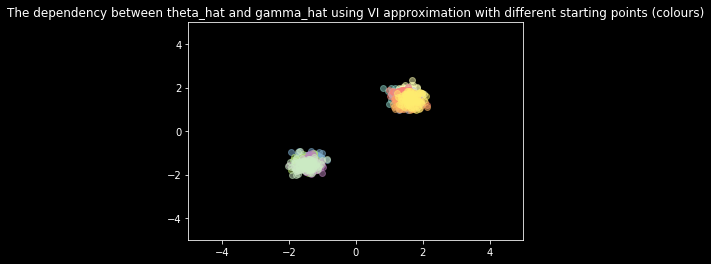

In [15]:
for run in range(10):
    print("")
    print("---")
    print(f"run {run}")
    svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

    pyro.clear_param_store()
    num_iters = 5000
    for i in range(num_iters):
        elbo = svi.step(x)
        if i % 1000 == 0:
            print(f"Elbo loss: {elbo:.2f}")
    par, distr = guide(x)
    samples = {key : distr.sample((100,)) for key, distr in distr.items()}

    theta_hat = samples['theta']
    gamma_hat = samples['gamma']
    plt.scatter(theta_hat, gamma_hat, alpha = 0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title("The dependency between theta_hat and gamma_hat using VI approximation with different starting points (colours)")